Using the equations of motion and the trivial derivative equations:

theta defined as the rotation along the positive y direction

$
\begin{aligned}
& F_x = \dot{v_x}m = (u_1 + u_2 + u_3) \sin(\theta)\\
& F_z = \dot{v_z}m = (u_1 + u_2 + u_3)\cos (\theta) - mg\\
& M_y = (u_3-u_1)L_{ca}\\
& \\
& \dot p_x = v_x\\
& \dot p_z = v_z\\
& \dot \theta = q
\end{aligned}
$

Rearranging gives the following state space equations:

$
x = 
\begin{bmatrix}
p_x\\
p_z\\
\theta\\
v_x\\
v_z\\
q
\end{bmatrix}
$

$
\dot x = 
\begin{bmatrix}
v_x\\
v_z\\
q\\
\frac{(u_1 + u_2 + u_3)\sin(\theta)}{m}\\
\frac{(u_1 + u_2 + u_3)\cos \theta}{m} - g\\
\frac{(u_3-u_1)L_{ca}}{I}
\end{bmatrix}
$

Let's try to implement this in rockit

c:\Users\32478\miniconda3\envs\rockit\python.exe


C:\Users\32478\AppData\Local\Temp\ipykernel_13252\3465502249.py:188: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  ocp.add_objective(sum(s.T for s in stages))
C:\Users\32478\AppData\Local\Temp\ipykernel_13252\3465502249.py:275: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(subcaves))


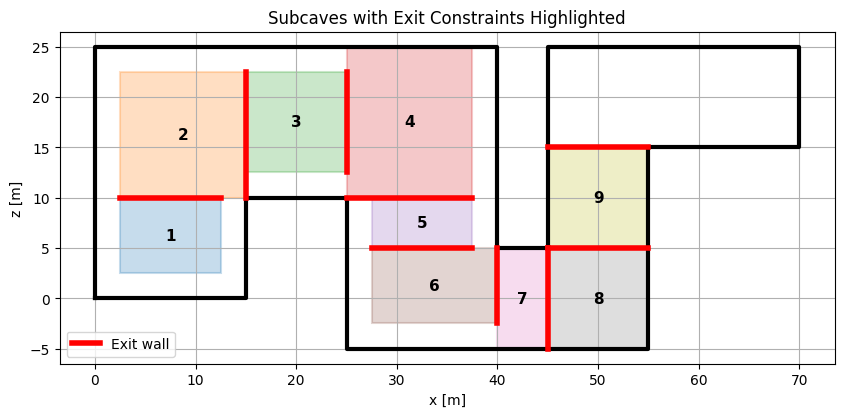

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     5169
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:     2760

Total number of variables............................:      980
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      675
Total number of inequality constraints...............:      780
        inequality constraints with only lower bounds:      230
   inequality constraints with lower and upper bounds:      330
        inequality constraints with only upper bounds:      220

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+02 6.25e+01 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

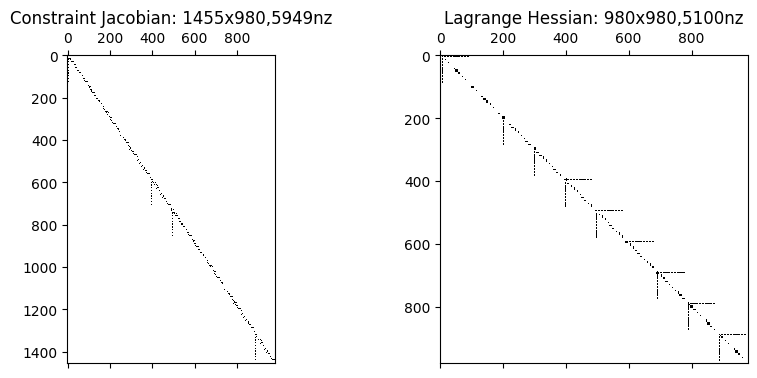

In [72]:
# from rockit import *
from rockit import Ocp, DirectMethod, MultipleShooting, FreeTime
import casadi as cs
from numpy import sin, pi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import numpy as np

import sys
print(sys.executable)


PLOT_CAVE_WALL_CONSTRAINTS = True
PI = np.pi

# ocp = Ocp(T=FreeTime(35.0))
N_steps = 40 # Define N here to use it for linspace

# Define constants
g = 1.625 # m/s^2
m = 4280.0 # kg
L_ca = 2.11 # m
I = 1000 # kg*m^2
F_max_1 = 2500 # N
F_max_2 = 10000 # N (center one is stronger)
F_max_3 = 2500 # N

# Fuel consumption is ~ force², center engine is twice as efficient
consumption_coeff_1 = 1.0
consumption_coeff_2 = 0.5
consumption_coeff_3 = 1.0


real_lander_radius = 2.5
effective_lander_radius = real_lander_radius # effective radius for circle constraints




# Lagrange objective
# ocp.add_objective(60*ocp.T)
# penalty on q angular velocity
# ocp.add_objective(ocp.integral(q**2))
#ocp.add_objective(ocp.integral(p_z**2))
# ocp.add_objective(ocp.integral(60*(theta**2)))
# ocp.add_objective(ocp.integral(60*q**2))

# Path constraints

# ocp.subject_to(-PI/2 <= (theta <= PI/2))

# # Plot initial guide to reach the target
# waypoints_x = [7.5, 10, 30.0, 35.0, 48.0, 51.0, 62.5]
# waypoints_z = [2.5, 15.0, 15.0, 0.0, 0.0, 19.5, 17.5]

# # 2. Interpolate these points to match the discretization grid
# # States in MultipleShooting are typically defined at N+1 points
# t_waypoints = np.linspace(0, 1, len(waypoints_x))
# t_grid = np.linspace(0, 1, N_steps + 1)

# p_x_guess = np.interp(t_grid, t_waypoints, waypoints_x)
# p_z_guess = np.interp(t_grid, t_waypoints, waypoints_z)

# # 3. Set the initial guesses on the OCP object
# ocp.set_initial(p_x, p_x_guess)
# ocp.set_initial(p_z, p_z_guess)

# # Also provide a guess for the main engine to hover (counteract gravity)
# # This helps the solver avoid "falling" immediately in the first iteration
# ocp.set_initial(u_2, m * g)


# # Initial constraints
# ocp.subject_to(ocp.at_t0(p_x)==7.5)
# ocp.subject_to(ocp.at_t0(p_z)==2.5)
# ocp.subject_to(ocp.at_t0(v_x)==0)
# ocp.subject_to(ocp.at_t0(v_z)==0)
# ocp.subject_to(ocp.at_t0(theta)==0)
# ocp.subject_to(ocp.at_t0(v_z)==0)


# End constraints as part of the objective -> easier to solve
final_x = 62.5
final_z = 17.5
# Add soft constraints (Mayer objective terms)
# Use a high weight to prioritize reaching the target
w_terminal = 100
# ocp.add_objective(w_terminal * (ocp.at_tf(p_x) - final_x)**2)
# ocp.add_objective(w_terminal * (ocp.at_tf(p_z) - final_z)**2)
# ocp.add_objective(w_terminal * (ocp.at_tf(v_x))**2)
# ocp.add_objective(w_terminal * (ocp.at_tf(v_z))**2)
# ocp.add_objective(w_terminal * 10 * (ocp.at_tf(theta))**2)
# ocp.add_objective(w_terminal * 100 * (ocp.at_tf(q))**2)

# Set initial guesss:
# ocp.set_initial(p_x, np.linspace(7.5, 62.5, N_steps))
# ocp.set_initial(p_z, np.linspace(2.5, 17.5, N_steps))
# ocp.set_initial(u_2, m*g/2) # Guess hovering thrust




X_MIN, X_MAX = 0.0, 70.0
Z_MIN, Z_MAX = -5.0, 25.0

real_lander_radius = 2.5
effective_lander_radius = real_lander_radius # effective radius for circle constraints

# Define Entire Cave Polygon
cave_x = [0, 15, 15, 25, 25, 55, 55, 70, 70, 45, 45, 40, 40, 0, 0]
cave_z = [0, 0, 10, 10, -5, -5, 15, 15, 25, 25, 5, 5, 25, 25, 0]

r = effective_lander_radius
# Define concave cave sections
subcaves = [
    ([0 + r, 15 - r], [0 + r, 10]),
    ([0 + r, 15], [10, 25-r]),
    ([15, 25], [10+r, 25-r]),
    ([25, 40 - r], [10, 25]),
    ([25 + r, 40 - r], [5, 10]),
    ([25 + r, 40], [-5 + r, 5]),
    ([40, 45], [-5, 5]),
    ([45, 55], [-5, 5]),
    ([45, 55], [5, 15]),
    ([45, 70], [15, 25]),
]






ocp = Ocp()
def create_lander_stage(ocp, subcave):
    sx, sz = subcave
    x0, x1 = sx
    z0, z1 = sz
    
    stage = ocp.stage(t0=FreeTime(0), T=FreeTime(10.0))
    # define states
    p_x = stage.state()   # position x
    p_z = stage.state()   # position z
    theta = stage.state() # angle
    v_x = stage.state()   # velocity x
    v_z = stage.state()   # velocity z
    q = stage.state()     # angular velocity

    # define controls
    u_1 = stage.control() # thrust engine 1
    u_2 = stage.control() # thrust engine 2
    u_3 = stage.control() # thrust engine 3

    # define ODEs
    stage.set_der(p_x, v_x)
    stage.set_der(p_z, v_z)
    stage.set_der(theta, q)
    stage.set_der(v_x, (u_1 + u_2 + u_3) * cs.sin(theta) / m)
    stage.set_der(v_z, (u_1 + u_2 + u_3) * cs.cos(theta) / m - g)
    stage.set_der(q, (L_ca * (u_3 - u_1)) / I)
    
    # Set subcave wall constraints
    stage.subject_to(p_x >= x0)
    stage.subject_to(p_x <= x1)
    stage.subject_to(p_z >= z0)
    stage.subject_to(p_z <= z1)
    
    stage.subject_to(0 <= (u_1 <= F_max_1))
    stage.subject_to(0 <= (u_2 <= F_max_2))
    stage.subject_to(0 <= (u_3 <= F_max_3))
    
    stage.method(MultipleShooting(N=10, M=1))
    # stage.add_objective(stage.T) # minimize time for each stage

    return stage, (p_x, p_z, theta, v_x, v_z, q), (u_1, u_2, u_3)

stages = []
states = []
controls = []

for c in subcaves:
    stage, x, u = create_lander_stage(ocp, c)
    stages.append(stage)
    states.append(x)
    controls.append(u)

# Minimize total time across all stages
ocp.add_objective(sum(s.T for s in stages))

# Initial conditions
ocp.subject_to(stages[0].at_t0(states[0][0]) == 7.5)
ocp.subject_to(stages[0].at_t0(states[0][1]) == 2.5)
ocp.subject_to(stages[0].at_t0(states[0][2]) == 0)
ocp.subject_to(stages[0].at_t0(states[0][3]) == 0)
ocp.subject_to(stages[0].at_t0(states[0][4]) == 0)
ocp.subject_to(stages[0].at_t0(states[0][5]) == 0)

# Continuity
for k in range(len(stages)-1):
    for i in range(6):
        ocp.subject_to(
            stages[k+1].at_t0(states[k+1][i])
            ==
            stages[k].at_tf(states[k][i])
        )

# Final landing
px, pz, th, vx, vz, q = states[-1]
ocp.subject_to(stages[-1].at_tf(px) == final_x)
ocp.subject_to(stages[-1].at_tf(pz) == final_z)
ocp.subject_to(stages[-1].at_tf(vx) == 0)
ocp.subject_to(stages[-1].at_tf(vz) == 0)
ocp.subject_to(stages[-1].at_tf(th) == 0)
ocp.subject_to(stages[-1].at_tf(q) == 0)

# Cave 1: exit on the top wall
ocp.subject_to(stages[0].at_tf(states[0][1]) == subcaves[0][1][1]) # states[stage][state_index], subcaves[cave_index][x/z][min/max_index]

# Cave 2: exit on the right wall
ocp.subject_to(stages[1].at_tf(states[1][0]) == subcaves[1][0][1])

# Cave 3: exit on the right wall
ocp.subject_to(stages[2].at_tf(states[2][0]) == subcaves[2][0][1])

# Cave 4: exit on the bottom wall
ocp.subject_to(stages[3].at_tf(states[3][1]) == subcaves[3][1][0])

# Cave 5: exit on the bottom wall
ocp.subject_to(stages[4].at_tf(states[4][1]) == subcaves[4][1][0])

# Cave 6: exit on the right wall
ocp.subject_to(stages[5].at_tf(states[5][0]) == subcaves[5][0][1])

# Cave 7: Exit on the right wall
ocp.subject_to(stages[6].at_tf(states[6][0]) == subcaves[6][0][1])

# Cave 8: exit on the top wall
ocp.subject_to(stages[7].at_tf(states[7][1]) == subcaves[7][1][1])

# Cave 9: exit on the top wall
ocp.subject_to(stages[8].at_tf(states[8][1]) == subcaves[8][1][1])


exits = [
    ("z", "max"),  # Cave 1: top
    ("x", "max"),  # Cave 2: right
    ("x", "max"),  # Cave 3: right
    ("z", "min"),  # Cave 4: bottom
    ("z", "min"),  # Cave 5: bottom
    ("x", "max"),  # Cave 6: right
    ("x", "max"),  # Cave 7: right
    ("z", "max"),  # Cave 8: top
    ("z", "max"),  # Cave 9: top
]
def draw_exit(ax, sx, sz, axis, side, color="red", lw=4):
    x0, x1 = sx
    z0, z1 = sz

    if axis == "x":
        x = x1 if side == "max" else x0
        ax.plot([x, x], [z0, z1], color=color, lw=lw)
    elif axis == "z":
        z = z1 if side == "max" else z0
        ax.plot([x0, x1], [z, z], color=color, lw=lw)



if PLOT_CAVE_WALL_CONSTRAINTS:
    
    fig, ax = plt.subplots(figsize=(10, 6))

    # Entire cave outline
    ax.plot(cave_x, cave_z, lw=3, color="black", label="Entire cave")

    cmap = cm.get_cmap("tab10", len(subcaves))

    for i, ((sx, sz), (axis, side)) in enumerate(zip(subcaves, exits)):
        x0, x1 = sx
        z0, z1 = sz

        color = cmap(i)

        # Subcave rectangle
        rect = patches.Rectangle(
            (x0, z0),
            x1 - x0,
            z1 - z0,
            linewidth=1.5,
            edgecolor=color,
            facecolor=color,
            alpha=0.25
        )
        ax.add_patch(rect)

        # Label
        ax.text(
            (x0 + x1)/2,
            (z0 + z1)/2,
            f"{i+1}",
            ha="center",
            va="center",
            fontsize=11,
            weight="bold"
        )

        # Exit wall
        draw_exit(ax, sx, sz, axis, side)

    ax.set_xlabel("x [m]")
    ax.set_ylabel("z [m]")
    ax.set_title("Subcaves with Exit Constraints Highlighted")
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True)

    # Legend proxy
    from matplotlib.lines import Line2D
    legend_lines = [
        Line2D([0], [0], color="red", lw=4, label="Exit wall")
    ]
    ax.legend(handles=legend_lines)

    plt.show()


# Pick a solver for the discretized NLP
ocp.solver('ipopt', {'ipopt': {"max_iter": 500}})

# Choose a solution method to transcribe the OCP into an NLP (discretization)
# ocp.method(MultipleShooting(N=N_steps, M=1, intg='rk'))

# We can also try single shooting
# ocp.method(SingleShooting(N=N_steps, intg='rk'))


# Visualize the OCP
ocp.spy()

# solve
try:
    sol = ocp.solve()
    print("Solver succeeded.")
except Exception as e:
    print("\n=== Solver FAILED, using debug values ===")
    print("Failure message:", e)

    opti = ocp._method.opti    # access internal Opti instance

    class FailedSolution:
        """Stage-aware debug wrapper so sol(stage).sample(...) works when solve() fails."""
        def __init__(self, opti):
            self.opti = opti

        def __call__(self, stage):
            return FailedStageSolution(stage, self.opti)

    class FailedStageSolution:
        def __init__(self, stage, opti):
            self.stage = stage
            self.opti = opti

        def sample(self, expr, grid="control", refine=None, **kwargs):
            # Sample on the *stage* (multi-stage safe), then evaluate with Opti debug values.
            if refine is not None:
                kwargs = dict(kwargs)
                kwargs["refine"] = refine
            t_sym, x_sym = self.stage.sample(expr, grid=grid, **kwargs)
            t_val = self.opti.debug.value(t_sym)
            x_val = self.opti.debug.value(x_sym)
            if hasattr(t_val, 'full'): t_val = t_val.full().flatten()
            if hasattr(x_val, 'full'): x_val = x_val.full().flatten()
            return t_val, x_val

    sol = FailedSolution(opti)


In [ ]:
## Make figures and do post-processing
from pylab import *

# Loop over all subcaves and store the states and controls
px_all = []
pz_all = []
vx_all = []
vz_all = []
theta_all = []
q_all = []
t_all = []
# controls
u1_all = []
u2_all = []
u3_all = []

t_offset = 0.0

for i in range(len(stages)):
    stage = stages[i]
    stage_sol = sol(stage)
    px_i, pz_i, th_i, vx_i, vz_i, q_i = states[i]

    t_i, px_val = stage_sol.sample(px_i, grid='control')
    _,  pz_val = stage_sol.sample(pz_i, grid='control')
    _,  th_val = stage_sol.sample(th_i, grid='control')
    _,  vx_val = stage_sol.sample(vx_i, grid='control')
    _,  vz_val = stage_sol.sample(vz_i, grid='control')
    _,  q_val  = stage_sol.sample(q_i,  grid='control')
    
    # Do the same for control
    _, u1_val = stage_sol.sample(controls[i][0], grid='control')
    _, u2_val = stage_sol.sample(controls[i][1], grid='control')
    _, u3_val = stage_sol.sample(controls[i][2], grid='control')

    # Shift time so stages connect
    t_i = t_i + t_offset
    t_offset = t_i[-1]

    t_all.append(t_i)
    px_all.append(px_val)
    pz_all.append(pz_val)
    theta_all.append(th_val)
    vx_all.append(vx_val)
    vz_all.append(vz_val)
    q_all.append(q_val)
    
    u1_all.append(u1_val)
    u2_all.append(u2_val)
    u3_all.append(u3_val)


t_all     = np.concatenate(t_all)
px_all    = np.concatenate(px_all)
pz_all    = np.concatenate(pz_all)
theta_all = np.concatenate(theta_all)
vx_all    = np.concatenate(vx_all)
vz_all    = np.concatenate(vz_all)
q_all     = np.concatenate(q_all)
u1_all    = np.concatenate(u1_all)
u2_all    = np.concatenate(u2_all)
u3_all    = np.concatenate(u3_all)


# # Post-processing
# tsa, pa_x = sol.sample(p_x, grid='control')
# tsa, va_x = sol.sample(v_x, grid='control')
# # for z direction
# tsa, pa_z = sol.sample(p_z, grid='control')
# tsa, va_z = sol.sample(v_z, grid='control')
# # for theta
# tsa, theta_a = sol.sample(theta, grid='control')
# tsa, q_a = sol.sample(q, grid='control')

# tsb, pb_x = sol.sample(p_x, grid='integrator', refine=5)
# tsb, vb_x = sol.sample(v_x, grid='integrator', refine=5)
# # for z direction
# tsb, pb_z = sol.sample(p_z, grid='integrator', refine=5)
# tsb, vb_z = sol.sample(v_z, grid='integrator', refine=5)
# # for theta
# tsb, theta_b = sol.sample(theta, grid='integrator', refine=5)
# tsb, q_b = sol.sample(q, grid='integrator', refine=5)



figure(figsize=(10,4))

subplot(1,3,1)
plot(t_all, px_all)
xlabel("Time [s]")
ylabel("p_x")
grid(True)

subplot(1,3,2)
plot(t_all, vx_all)
xlabel("Time [s]")
ylabel("v_x")
grid(True)

subplot(1,3,3)
plot(t_all, np.rad2deg(theta_all))
xlabel("Time [s]")
ylabel("theta [deg]")
grid(True)

plt.show()


figure()
step(t_all,u1_all,where='post')
step(t_all,u2_all,where='post')
step(t_all,u3_all,where='post')
title("Control signal")
xlabel("Times [s]")
legend(['u_1','u_2','u_3'])
grid(True)

plt.show(block=True)

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

PLOT_FEASIBLE_REGION = False

# Sample controls on the same grid as states for animation
# tsb, ub_1 = sol.sample(u_1, grid='integrator', refine=5)
# tsb, ub_2 = sol.sample(u_2, grid='integrator', refine=5)
# tsb, ub_3 = sol.sample(u_3, grid='integrator', refine=5)

# Show the feasible region
# Define grid for visualization
if PLOT_FEASIBLE_REGION:
    xs = np.linspace(X_MIN, X_MAX, 400)
    zs = np.linspace(Z_MIN, Z_MAX, 300)
    R2 = (effective_lander_radius + wall_radius)**2

    feasible = np.zeros((len(zs), len(xs)), dtype=bool)

    for ix, x in enumerate(xs):
        for iz, z in enumerate(zs):
            ok = True
            # Circle constraints
            for ox, oz, r in wall_obstacles:
                if (x - ox)**2 + (z - oz)**2 < R2:
                    ok = False
                    break
            # Box constraints
            if not (X_MIN + real_lander_radius <= x <= X_MAX - real_lander_radius):
                ok = False
            if not (Z_MIN + real_lander_radius <= z <= Z_MAX - real_lander_radius):
                ok = False
            feasible[iz, ix] = ok

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_aspect('equal')
ax.grid(True)
ax.set_xlabel('X [m]')
ax.set_ylabel('Z [m]')
ax.set_title('Moonlander Animation')
# Plot Cave
ax.plot(cave_x, cave_z, 'k-', linewidth=2, label='Cave Walls')

if PLOT_FEASIBLE_REGION:
    # Plot feasible region as a green mask
    extent = [xs[0], xs[-1], zs[0], zs[-1]]
    ax.imshow(feasible, extent=extent, origin='lower', cmap='Greens', alpha=0.5)


# Set limits based on trajectory
x_min, x_max = np.min(px_all), np.max(px_all)
z_min, z_max = np.min(pz_all), np.max(pz_all)
margin = 5
# minimum of cave dimesions
ax.set_xlim(min(cave_x) - margin, max(cave_x) + margin)
ax.set_ylim(min(cave_z) - margin, max(cave_z) + margin)

# Elements to animate
lander_body, = ax.plot([], [], 'k-', linewidth=2)
trajectory, = ax.plot([], [], 'b--', alpha=0.5)
# Thrusters (lines)
thrust_1, = ax.plot([], [], 'r-', linewidth=2)
thrust_2, = ax.plot([], [], 'r-', linewidth=2)
thrust_3, = ax.plot([], [], 'r-', linewidth=2)

time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

# Lander geometry
w = 4  # width
h = 2  # height
# Define a rectangle centered at 0,0
body_pts = np.array([
    [-w/2, -h/2],
    [w/2, -h/2],
    [w/2, h/2],
    [-w/2, h/2],
    [-w/2, -h/2]
])

# Thruster positions relative to center
try:
    l_dist = L_ca
except NameError:
    l_dist = 2.11

thruster_origins = np.array([
    [-l_dist, -h/2], # u1
    [0, -h/2],       # u2
    [l_dist, -h/2]   # u3
])

# Scaling factor for thrust visualization
max_thrust = max(np.max(u1_all), np.max(u2_all), np.max(u3_all))
scale = 5.0 / max_thrust if max_thrust > 0 else 1.0

def update(frame):
    # Get current state
    x = px_all[frame]
    z = pz_all[frame]
    th = theta_all[frame]
    t = t_all[frame]
    
    # Rotation matrix
    # Physics: Force ~ [sin(th), cos(th)]. 
    # We want Body Up [0,1] to align with Force.
    # R @ [0,1] = [sin, cos] => R = [[cos, sin], [-sin, cos]]
    c, s = np.cos(th), np.sin(th)
    R = np.array([[c, s], [-s, c]])
    
    # Transform body points
    current_body = (R @ body_pts.T).T + np.array([x, z])
    lander_body.set_data(current_body[:, 0], current_body[:, 1])
    
    # Trajectory
    trajectory.set_data(px_all[:frame+1], pz_all[:frame+1])
    
    # Thrusters
    u = [u1_all[frame], u2_all[frame], u3_all[frame]]
    thrust_lines = [thrust_1, thrust_2, thrust_3]
    
    for i in range(3):
        if u[i] > 1e-3: # Only draw if active
            # Start point (relative)
            p0_rel = thruster_origins[i]
            # End point (relative) - pointing down (negative y in local frame)
            # Length proportional to thrust
            length = u[i] * scale
            p1_rel = p0_rel + np.array([0, -length])
            
            # Transform to global
            p0 = (R @ p0_rel) + np.array([x, z])
            p1 = (R @ p1_rel) + np.array([x, z])
            
            thrust_lines[i].set_data([p0[0], p1[0]], [p0[1], p1[1]])
        else:
            thrust_lines[i].set_data([], [])

    time_text.set_text(f'Time: {t:.2f} s')
    
    return lander_body, trajectory, thrust_1, thrust_2, thrust_3, time_text

# Create animation
dt = t_all[1] - t_all[0] if len(t_all) > 1 else 0.1

# OPTIMIZATION: Skip frames to speed up HTML generation
# refine=5 generates many frames. We can skip some for playback.
skip_frames = 1
interval = dt * 1000 * skip_frames
interval = max(20, min(interval, 200)) # Keep frame rate reasonable

ani = FuncAnimation(fig, update, frames=range(0, len(t_all), skip_frames), interval=interval, blit=True)



plt.close(fig)
HTML(ani.to_jshtml())
